# Flowers image classification: https://www.kaggle.com/ianmoone0617/flower-goggle-tpu-classification
The task is to train a machine learning neural network model to classify a number of flower pictures. 

### Import libraries

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Preparing data

In [5]:
subdir = "../input/flower-goggle-tpu-classification"

Get general information of flower id and flower class

In [7]:
# get flower id
df_idx = pd.read_csv(os.path.join(subdir, "flowers_idx.csv"))
df_idx.head()

,id,flower_cls
0,7486,cape flower
1,9454,cape flower
2,6974,cape flower
3,4739,cape flower
4,8783,cape flower


In [8]:
len(df_idx.flower_cls.unique())

104

In [9]:
# total data for classification
len(df_idx)

16465

In [10]:
# get flower labels
df_label = pd.read_csv(os.path.join(subdir, "flowers_label.csv"))
df_label.head()

,label,flower_class
0,0,pink primrose
1,1,hard-leaved pocket orchid
2,2,canterbury bells
3,3,sweet pea
4,4,wild geranium


In [11]:
# total number of labels
len(df_label)

104

All the flower figures in the training directory have been classified, there are in total 104 classess. 
Look at how many flower images of each flower class

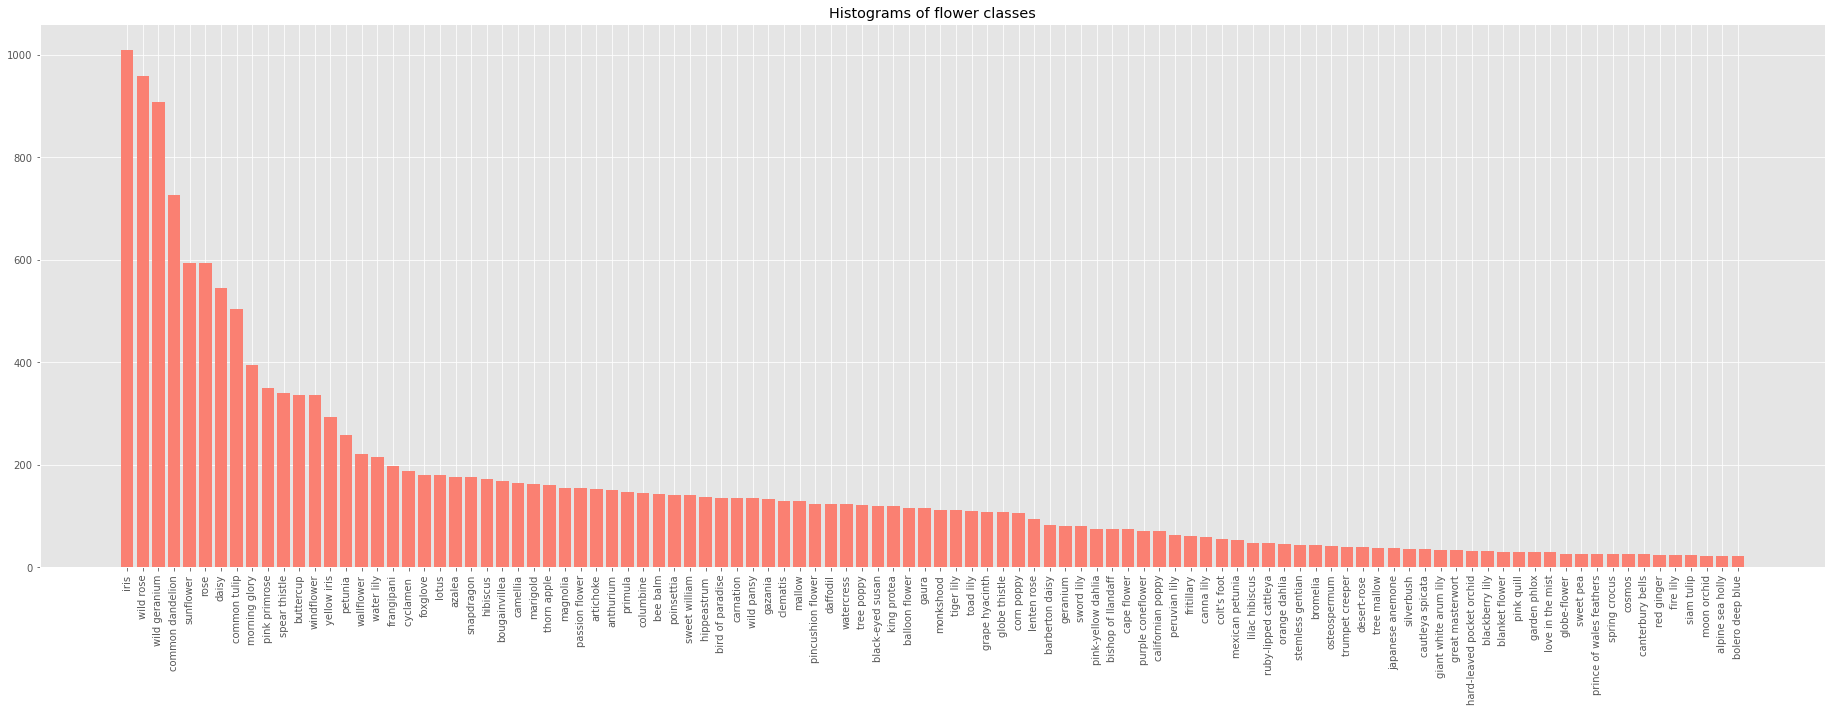

In [12]:
plt.style.use("ggplot")
df_counts = dict(df_idx["flower_cls"].value_counts()) # dictionary of different breeds and their value counts
plt.figure(figsize=(32, 10))
plt.bar(df_counts.keys(), df_counts.values(), color="salmon")
plt.title("Histograms of flower classes")
plt.xticks(rotation=90);

### Encoding flower classes
We need to translate the flower class in df_idx into a vector based on the flower class in df_idx, e.g., in df_idx, the id is '13030', its class is 'windflower', then, according to df_label, the label of the flower_class of 'windflower' is label X.   

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are '2', the correspoding vector for it would be [0, 0, 1, 0, 0, 0, 0, 0, 0,... 0], the length of the vector is 104.

We need to use some shorter vectors. 

Here, we decide to use binary code will greatly reduce the vector from 104 bits to 8 bits! So that we can keep using the existing models such as resnet14 used in the lecture notes.
Another issue here is that binary code is not maximally using the coding ability, by comparison, Gray code is better.

In [13]:
# for 104 flower classes, the minimum number of digits is 8
nodigit = 8

# helper function to transfer a decimal number into a string of binary number
def dec_to_bin(decno, numdigits=nodigit):
    binstr = bin(decno)[2:]
    binstr = binstr.zfill(numdigits)
    return binstr

def bin_to_dec(binstr):
    decno = 0
    for i in range(len(binstr)):
        if np.int64(binstr[i]) == 1: 
            decno += pow(2, (len(binstr)-1-i))
    return decno

In [21]:
# test
decno = 30
binstr = dec_to_bin(decno)
binstr

'00011110'

In [22]:
decno = bin_to_dec(binstr)
decno

30

In [23]:
# Helper function to transfer a decimal number into a gray code and vice versa
# Helper function to xor two characters 
def xor_c(a, b): 
    return '0' if(a == b) else '1' 

# Helper function to flip the bit 
def flip(c): 
    return '1' if(c == '0') else '0' 
  
# function to convert binary string yo gray string 
def bin_to_gray(binstr, numdigits=nodigit): 
    graystr = "" 
    # MSB of gray code is the same as binary code 
    graystr += binstr[0]  
    # Compute remaining bits, next bit is comuted by doing XOR of previous and current in Binary 
    for i in range(1, len(binstr)):         
        graystr += xor_c(binstr[i-1], binstr[i]) # Concatenate XOR of previous bit with current bit     
    graystr = graystr.zfill(numdigits) # add filling 0 in front
    return graystr 
  
# function to convert gray code 
# string to binary string 
def gray_to_bin(graystr, numdigits=nodigit): 
    binstr = "" 
    # MSB of binary code is the same as gray code 
    binstr += graystr[0] 
    # Compute remaining bits 
    for i in range(1, len(graystr)): 
        if graystr[i] == '0': binstr += binstr[i-1] # If current bit is 0, concatenate previous bit     
        else: binstr += flip(binstr[i-1]) # Else, concatenate invert of previous bit 
    binstr = binstr.zfill(numdigits) # add filling 0 in front
    return binstr

In [159]:
# test Code
decno = 123
graystr = bin_to_gray(dec_to_bin(decno))
print(graystr) 

decno = bin_to_dec(gray_to_bin(graystr))
print(decno) 

01000110
123


In [162]:
# define a helper function to translate the vector to flower_class
def encode_class(flower_class, numdigits=nodigit):
    label = df_label.label[df_label.flower_class==flower_class].iloc[0] # find the label based on flower_class
    targetstr = bin_to_gray(dec_to_bin(np.int64(label), numdigits=nodigit), numdigits=nodigit)
    target = torch.zeros(numdigits)
    for l in range(len(targetstr)):
        target[l] = np.int64(targetstr[l])
    return target

def decode_target(target, text_labels=False, threshold=0.5, numdigits=nodigit):
    clntarget = []
    for i, x in enumerate(target):
        if float(x) >= threshold: clntarget.append(1)
        if float(x) < threshold: clntarget.append(0)
    targetstr = ''.join([str(x) for x in clntarget])
    decno = bin_to_dec(gray_to_bin(targetstr, numdigits=nodigit))
    if decno >= 104: decno = 103
    if text_labels: result = df_label.flower_class[decno]
    else: result = decno
    return result

In [26]:
# test: encode a label
encode_class('windflower')

tensor([0., 1., 1., 0., 0., 1., 1., 0.])

In [163]:
# decode a vector
vec = torch.tensor([0, 1, 0, 0, 0, 1, 1, 0])
decode_target(vec)

103

In [164]:
decode_target(vec, text_labels=True)

'wild rose'

### Set up dataset

In [156]:
class FlowerDataset(Dataset):
    def __init__(self, label_df, root_dir, transform=None):
        self.df = label_df # df for flower_classes, note that this df can be randomly classified for later correction
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_label, img_class = row['id'], row['flower_cls']
        img_fname = os.path.join(self.root_dir, str(img_label) + ".jpeg")
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_class(img_class)

In [31]:
Tds = T.Compose([
    T.RandomCrop(32, padding=4), # random crop
    T.RandomHorizontalFlip(), # random horizontal flip-flop
    T.Resize((200,200)), T.ToTensor()])

Ttest = T.Compose([T.Resize((200,200)), T.ToTensor()])

label_df = pd.read_csv(os.path.join(subdir, "flowers_idx.csv")) # for training data, the figures are already classified 
root_dir = os.path.join(subdir, "flower_tpu", "flower_tpu", "flowers_google", "flowers_google")

In [32]:
dataset = FlowerDataset(label_df, root_dir, transform=Tds)

show an image sample

In [165]:
def show_sample(img, target):
    plt.imshow(img.permute(1,2,0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: cape flower


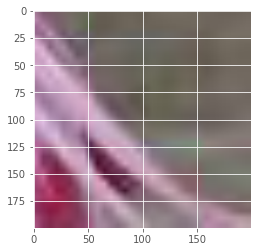

In [34]:
show_sample(*dataset[1])

In [35]:
torch.manual_seed(60) # setup random seed

In [36]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [37]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(14819, 1646)

Data Loaders

In [38]:
batch_size = 128

In [39]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [40]:
def show_batch(dl):
    for img, label in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = img
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

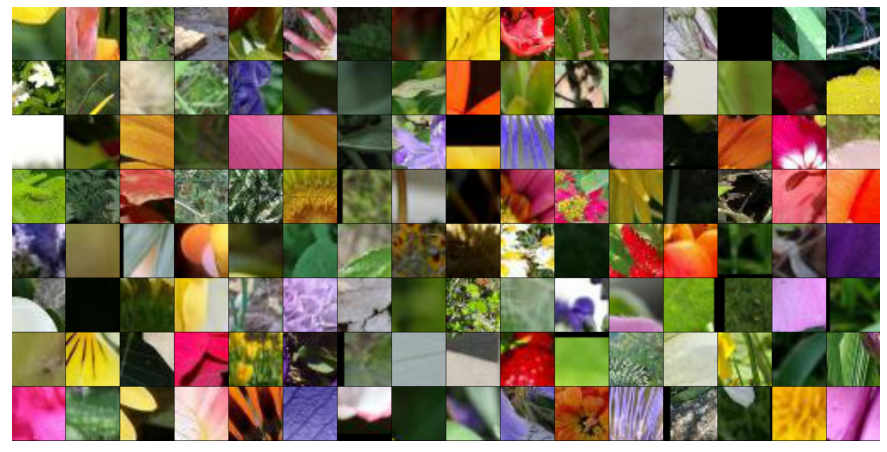

In [41]:
show_batch(train_dl)

## Defining the model

In [42]:
# helper function to calculate F_score
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    
    # define four numbers for evaluation of F-score (TP, TN, FP, FN)
    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [43]:
# helper function of model base
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [127]:
# ResNet34
class FlowerResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, nodigit) # change the output node number
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True          

In [47]:
# use self-defined cnn model
class FlowerCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),            
            nn.Conv2d(16, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 64 * 16 * 16
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 128 * 8 * 8
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 128 * 4 * 4
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 256 * 2 * 2
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 512 * 1 * 1
            nn.AdaptiveAvgPool2d(1),
            
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, nodigit), # specify the number of nodes in the output
            nn.Sigmoid()
        ) 
        
    def forward(self, xb):
        return self.cnn(xb)

In [48]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [49]:
device = get_default_device()
device

device(type='cuda')

In [50]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

In [51]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Training model

In [52]:
from tqdm.notebook import tqdm

In [53]:
# helper function for evaluation (from course materials lecture 5)
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
# helper functions for figure drawing
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch'); plt.ylabel('score'); plt.title('F1 score vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.'); plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [55]:
# settings for training hyperparameters
epochs = 3
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [128]:
model1 = to_device(FlowerResnet(), device)
model1

FlowerResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [129]:
history1 = [evaluate(model1, val_dl)]
history1

[{'val_loss': 0.7195813655853271, 'val_score': 0.4111558496952057}]

### First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [131]:
model1.freeze()

In [132]:
%%time
history1 += fit_one_cycle(epochs, max_lr, model1, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.6011, val_loss: 0.6017, val_score: 0.4474



Epoch [1], train_loss: 0.5862, val_loss: 0.5824, val_score: 0.5759



Epoch [2], train_loss: 0.5789, val_loss: 0.5771, val_score: 0.5780
CPU times: user 53 s, sys: 28.7 s, total: 1min 21s
Wall time: 3min 43s


Now, unfreeze and train some more.### 

In [133]:
model1.unfreeze()

In [134]:
%%time
history1 += fit_one_cycle(epochs, 0.001, model1, train_dl, val_dl, 
                         grad_clip=grad_clip, weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.5777, val_loss: 0.5825, val_score: 0.5942



Epoch [1], train_loss: 0.5771, val_loss: 0.5777, val_score: 0.5785



Epoch [2], train_loss: 0.5729, val_loss: 0.5725, val_score: 0.5971
CPU times: user 53.6 s, sys: 29 s, total: 1min 22s
Wall time: 3min 47s


Let us see the other model

In [69]:
model2 = to_device(FlowerCnnModel(), device)
model2

FlowerCnnModel(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [78]:
history2 = [evaluate(model2, val_dl)]
history2

[{'val_loss': 0.595686137676239, 'val_score': 0.5136646628379822}]

In [79]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, val_dl, 
                         grad_clip=grad_clip,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.6028, val_loss: 0.5999, val_score: 0.5136



Epoch [1], train_loss: 0.5992, val_loss: 0.5980, val_score: 0.4201



Epoch [2], train_loss: 0.5985, val_loss: 0.5980, val_score: 0.5136
CPU times: user 9.33 s, sys: 5.17 s, total: 14.5 s
Wall time: 3min 18s


In [80]:
# model2 has no freeze, unfreeze functions
# we have to reinitiate model each time
model2 = to_device(FlowerCnnModel(), device)

In [81]:
%%time
history2 += fit_one_cycle(epochs, 0.001, model2, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.6244, val_loss: 0.5984, val_score: 0.4201



Epoch [1], train_loss: 0.5992, val_loss: 0.5970, val_score: 0.5136



Epoch [2], train_loss: 0.5970, val_loss: 0.5955, val_score: 0.5132
CPU times: user 9.14 s, sys: 5.2 s, total: 14.3 s
Wall time: 3min 9s


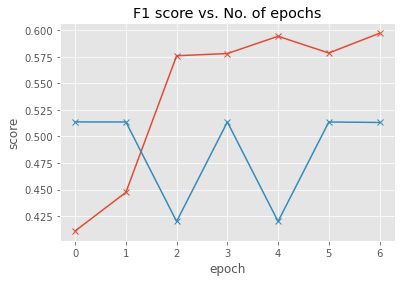

In [138]:
# show two models performance together
ax1 = plt.figure(1)
plot_scores(history1)
ax2 = plt.figure(1)
plot_scores(history2)

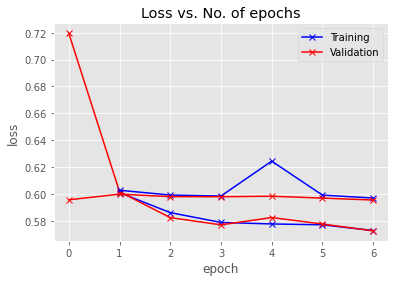

In [139]:
ax1 = plt.figure(1)
plot_losses(history1)
ax2 = plt.figure(1)
plot_losses(history2)

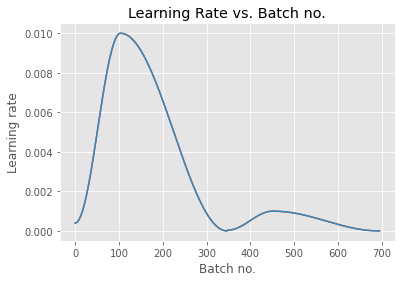

In [140]:
ax1 = plt.figure(1)
plot_lrs(history1)
ax2 = plt.figure(1)
plot_lrs(history2)

### Model 1 has better performance. Use Model 1 for prediction. 

### Making predictions and submission

In [142]:
def predict_single(image, model, show=True):
    xb = to_device(image.unsqueeze(0), device)
    preds = model(xb)
    prediction = preds[0]
    if show: 
        print("Prediction: ", prediction)
        show_sample(image, prediction)
    else: return decode_target(prediction, text_labels=True) 

## Create test data

In [144]:
import glob
testdir = os.path.join(subdir, "flower_tpu", "flower_tpu", "test", "test")
jpegFiles = glob.glob(os.path.join(testdir, "*.jpeg"))
test_df = pd.DataFrame(columns=['id', 'flower_cls'])
for fig in jpegFiles:
    idx = fig.split(testdir)[1].split(".jpeg")[0].split("/")[1]
    test_df = test_df.append({'id': idx, 'flower_cls': df_label['flower_class'].sample(n=1).iloc[0]}, ignore_index=True)


In [145]:
test_df.head()

,id,flower_cls
0,416e24d42,snapdragon
1,bbaef0141,bird of paradise
2,4c4fda276,bougainvillea
3,f0727012b,anthurium
4,2f230552c,bishop of llandaff


In [146]:
len(test_df)

7382

In [147]:
test_data = FlowerDataset(test_df, testdir, transform=Ttest)

In [148]:
img, target = test_data[0]
img.shape

torch.Size([3, 200, 200])

In [149]:
predict_single(test_data[122][0], model=model1, show=False)

'sunflower'

Prediction:  tensor([1.3384e-04, 6.4306e-01, 3.2456e-01, 7.3568e-01, 1.8961e-01, 7.8525e-01,
        5.2326e-01, 4.3590e-01], device='cuda:0', grad_fn=<SelectBackward>)
Labels: trumpet creeper


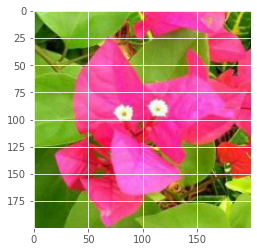

In [150]:
predict_single(test_data[123][0], model=model1)

let us predict all test images

In [166]:
test_dl = DeviceDataLoader(DataLoader(test_data, batch_size, num_workers=3, pin_memory=True), device)

In [167]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x, text_labels=True) for x in batch_probs]

In [168]:
test_preds = predict_dl(test_dl, model=model1)

In [169]:
submission_df = test_df
submission_df.flower_cls = test_preds
submission_df.head()

,id,flower_cls
0,416e24d42,iris
1,bbaef0141,wild pansy
2,4c4fda276,iris
3,f0727012b,blackberry lily
4,2f230552c,iris


In [171]:
len(submission_df.flower_cls.unique())

53

In [ ]:
the model only predicts 53 classes of flowers, smaller than the 104 classes in df_label

draw distribution histogram like the training data

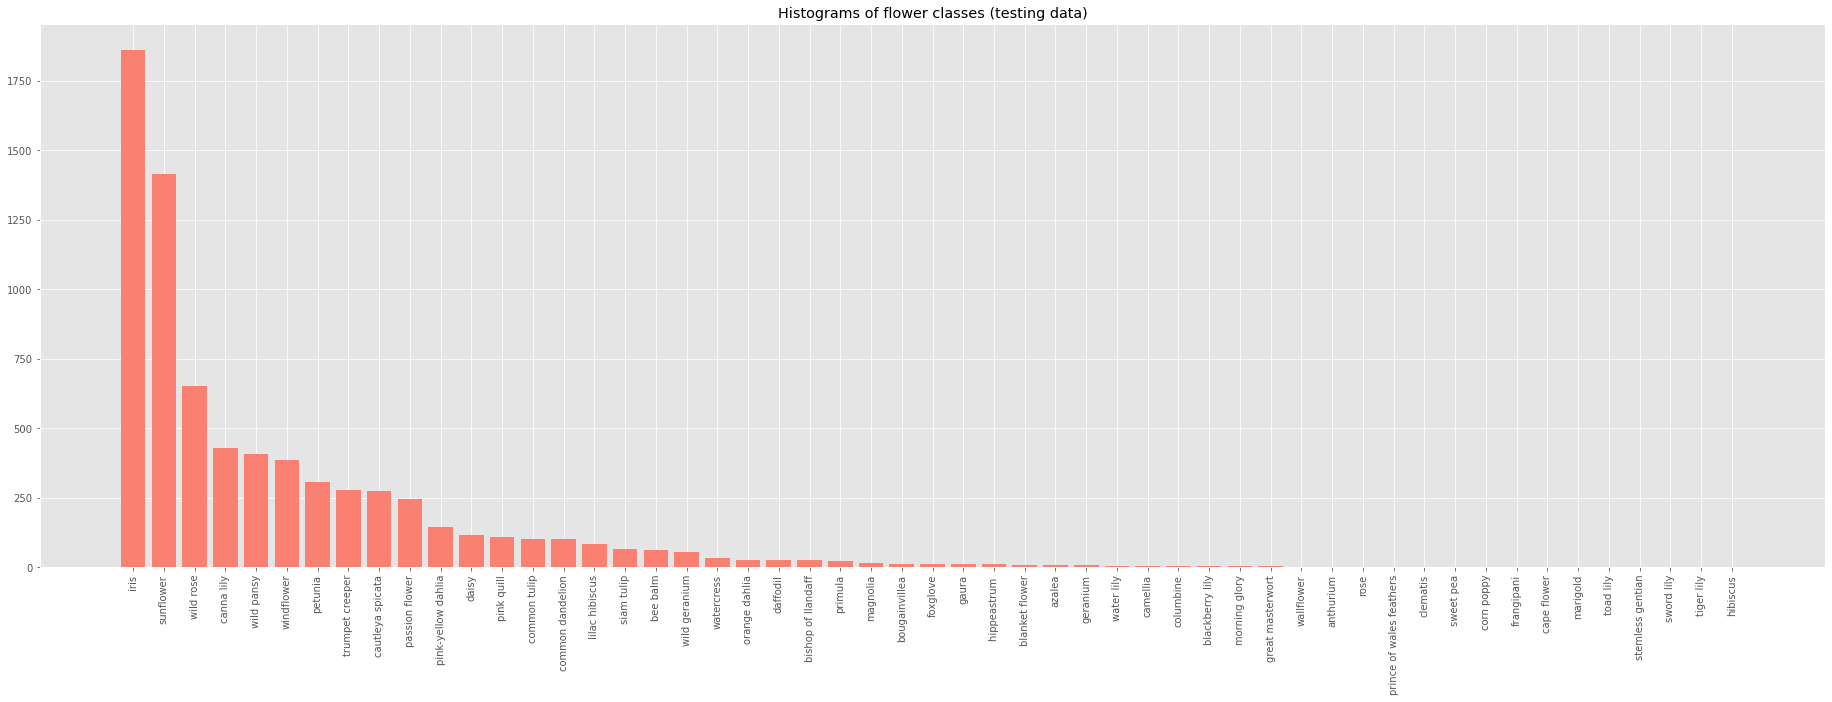

In [170]:
plt.style.use("ggplot")
testdf_counts = dict(test_df["flower_cls"].value_counts()) # dictionary of different breeds and their value counts
plt.figure(figsize=(32, 10))
plt.bar(testdf_counts.keys(), testdf_counts.values(), color="salmon")
plt.title("Histograms of flower classes (testing data)")
plt.xticks(rotation=90);

make a submission

In [172]:
sub_fname = 'submission_flowerclassification.csv'

In [173]:
submission_df.to_csv(sub_fname, index=False)

you can download the csv file and submit it online

## Save to Jovian

In [174]:
!pip install jovian --upgrade

     |████████████████████████████████| 94 kB 1.5 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=543b2ab3e177e9f8aea6c70766da4094660883d6471bf2b703561a05ee8acb05
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [175]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='pytorch_class_competitio')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/susan-shuai/pytorch_class_competitio


<IPython.core.display.Javascript object>